In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import binotools as bt
import astropy.io.fits as fits
from astropy.table import Table
import glob

# Current pipeline does not tell you where object is in the slit - can we find it??

Sean said to look in proc files for mask details and then use

    target_offset=((mask_entry.y-mask_entry.bbox[1])*5.98802)/0.24

to get source position in pixels from bottom of slit

In [2]:
datadir     = os.environ['BINO_DIR']+'2649_BLAS_1a_2019.0208/'
red_datadir = datadir + '2019.0208_red_4hrs_190219/'

In [14]:
fdark = 'calib/obj_dark.fits'
target_offset_px = bt.bino_get_obj_ypos(red_datadir+fdark)
print(target_offset_px)

[202.82716746  16.93465587  13.63734337  19.07946989  16.56546423
  48.48516999  23.77160154  29.811059    36.61945157  28.37645586
  16.38605555  17.54588265  16.42136623  22.35498685  12.50007322
  12.49997804  16.54395422  22.36697916  18.92466448  13.93348665
  23.81552573  12.49997804  12.50002563  41.25723714  18.83933828
  19.19558585  25.83189837  17.84183558  17.27091626  18.01127446
  12.50000184  19.4028338   12.49998994  28.75944817  13.38350627
  36.12125976  12.49998994  17.63875163  29.21115828  14.6811021
  12.50000184  18.79567583  24.39877048  14.4806831   31.47301624
  16.88345063  14.0107228   20.79470246  23.8578795   16.72198283
  33.3746292   25.71897085  12.49997804  12.49997804  18.03052401
  13.56948216  12.49997804  12.49997804  15.32426078  19.0293116
  18.21421565  22.26475904  12.49997804  27.11126781  12.49997804
  17.12900733  31.18646204  27.87458746  13.31945214  19.72591218
  21.44290552  12.49997804  28.26938172  17.42938599  19.8463111
  12.49997804

In [31]:
mm_to_arcsec = 5.98802
px_to_arcsec = 0.24

fdark = 'calib/obj_dark.fits'

dark_hdu = fits.open(red_datadir+fdark)

sideA = dark_hdu[3].data
ntargetsA = sideA['NTARGETS'][0]

sideB = dark_hdu[4].data
ntargetsB = sideB['NTARGETS'][0]


target_offset_px = []
slit_height_px   = []
for side in [sideA, sideB]:
    ntargets = side['NTARGETS'][0]

    # Object position on mask
    obj_y = side['SLITY'][0][:ntargets]
    
    # Bounding box of slit Y
    slit_poly_y = side['POLY_Y'][:,:,:ntargets]
    slit_bot = slit_poly_y[0,0,:]
    slit_top = slit_poly_y[0,1,:]
    slit_height_px.append((slit_top - slit_bot)*mm_to_arcsec/px_to_arcsec)

    # Position of slit bottom
    slit_y_bottom = slit_poly_y[0,0,:] # == mask_entry.bbox[1]

    # Pixel offset positions of objects in slits
    target_offset_px.append((obj_y - slit_y_bottom)*mm_to_arcsec/px_to_arcsec)

target_offset_px = np.array([item for sublist in target_offset_px for item in sublist])
slit_height_px   = np.array([item for sublist in slit_height_px for item in sublist])

In [15]:
datadir = os.environ['BINO_DIR']+'2649_BLAS_1a_2019.0208/2019.0208_red_4hrs_190219/'

slits_data_file = datadir+"obj-sky_slits_lin.fits"

In [16]:
bino_plot = bt.BinoPlotter(slits_data_file)

Text(0.5, 0, 'Extracted slit - mask design height')

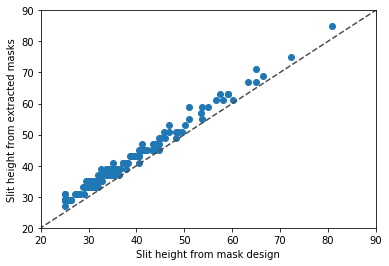

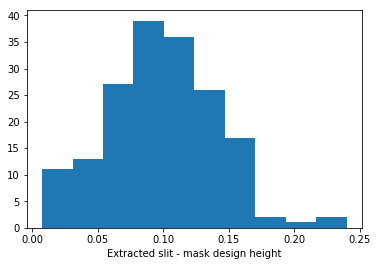

In [32]:
slit_height_px_fromextracted = []
for i, hdu in enumerate(bino_plot.hdu_list):
    if i > 0:
        slit_height_px_fromextracted.append(hdu.data.shape[0])
slit_height_px_fromextracted = np.array(slit_height_px_fromextracted)

plt.scatter(slit_height_px, slit_height_px_fromextracted)
# plt.xscale('log')
# plt.yscale('log')
x = np.linspace(0., 300)
plt.plot(x, x, ls='dashed', c='0.3')
plt.xlim(20, 90)
plt.ylim(plt.gca().get_xlim())
plt.xlabel('Slit height from mask design')
plt.ylabel('Slit height from extracted masks')

diff_height = (slit_height_px_fromextracted-slit_height_px)/slit_height_px

plt.figure()
plt.hist(diff_height)
plt.xlabel('Extracted slit - mask design height')

19.079469891548154
33


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/OIRtools-0.1.0-py3.7.egg/binotools/bino_plot.py:115: RuntimeWarning: invalid value encountered in greater


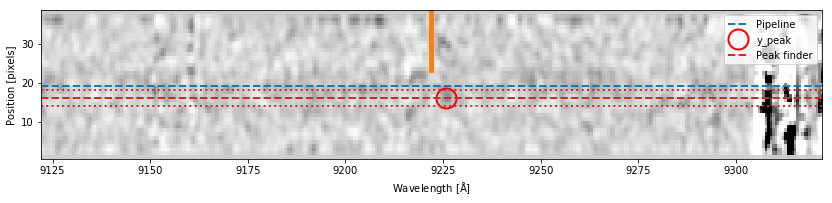

In [25]:
# Line to center on
Lya_wave  = 9188. # Wavelength to center on
Lya_wave  = 9222. # Wavelength to center on
posy_width = 4.    # Pixel width of extraction window for 1D spectrum (4 pix = PSF from stars ~1")
wave_limA = 30.   # Wavelength range to plot over (Lya_wave /pm wave_limA)

targetid = 4 # slit number ( mask id + 1)

ypos = target_offset_px[targetid-1]
print(ypos)

image, ypos = bino_plot.spec2D(target=targetid, wave_lineA=Lya_wave, 
                               posy_width=posy_width, posy=ypos,
                               vmin_sig=-0.3, vmax_sig=0.7, wave_limA=100.,
                               smooth=1.)
slit_ypix = image.shape[0]
nan_ypix = len(image[:,4000][np.isnan(image[:,4000])])
print(slit_ypix-nan_ypix)

In [26]:
# Load slit csv file (output from Binomask)
slits = pd.read_csv('../BLAS_config/BLAS_1_slits.csv')

# fits file ext # = slits.index + 1
slits['extnum'] = slits.index + 1

slits_lowz = slits[(slits.priority == 6.) | (slits.type == 'STANDARD')]
slits_lowz

,slit,targetnum,name,ra,dec,pmra,pmdec,mag,priority,epoch,type,wave_start,wave_end,side,extnum
0,22,778,3DHST_15563,188.950745,62.218903,0,0,0.001,6,2000,TARGET,7728.533648,10251.126548,A,1
1,23,818,3DHST_16476,188.950455,62.223740,0,0,0.001,6,2000,TARGET,7698.929822,10221.535552,A,2
2,27,872,3DHST_17848,188.946426,62.230289,0,0,0.001,6,2000,TARGET,7652.275725,10174.901935,A,3
3,33,908,3DHST_19025,188.946198,62.235584,0,0,0.001,6,2000,TARGET,7620.071986,10142.712164,A,4
4,37,931,3DHST_19661,188.949158,62.238186,0,0,0.001,6,2000,TARGET,7609.846845,10132.491259,A,5
5,36,919,3DHST_19285,188.968842,62.237110,0,0,0.001,6,2000,TARGET,7652.164596,10174.789393,A,6
6,35,918,3DHST_19281,188.978577,62.236897,0,0,0.001,6,2000,TARGET,7671.224746,10193.840674,A,7
7,32,902,3DHST_18839,188.993240,62.234818,0,0,0.001,6,2000,TARGET,7710.485386,10233.083389,A,8
8,44,999,3DHST_21508,188.987457,62.247871,0,0,0.001,6,2000,TARGET,7621.921607,10144.558506,A,9
9,46,1033,3DHST_22052,188.994080,62.250793,0,0,0.001,6,2000,TARGET,7616.667809,10139.306658,A,10


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[1.3985201913452145, 0.9443174078369133, -2.0070375912475584, 0.7390727739715569, -0.8242885857391357, -1.0835592024993894, -0.054815630950927244, -0.0453458391571047, 0.868668376998902, -1.589650593261719, -1.347346667175293, -0.3489881629943849, 0.10112789421081543, 2.0051968443298334, -0.8399824268341062, 0.13054901298522992, -0.39192500274658243, 0.4619194745254515, 0.46403679622650146, 0.675726175193787, -1.080005269317627, -0.11999384807586679, -1.4785588119506834, -1.240344390182495, -1.9579594604873656, 0.06501990211486827, -1.677294129199982, 0.12000044130325335, -0.29773243957519496, 1.9491023415496938, -0.11999955869674664, -1.5646360553932186, -0.5079718482971194, -0.7174265283966065, 1.1325530031204223, 1.079994730682373, -0.3600052693176269, 1.2073257630920418, 0.8566757180023196, 0.3599947306823731, -0.3600052693176269, 1.2070347851562495, -0.6564578300476074, 2.039994730682373, 1.2447508901977542, 1.134218922042847, -1.0937026752471926, 0.8230526371765137, 0.92311466369

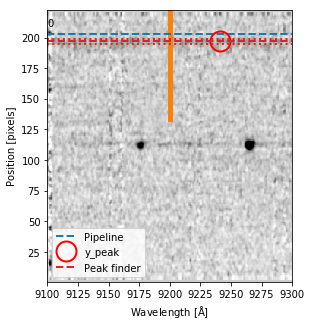

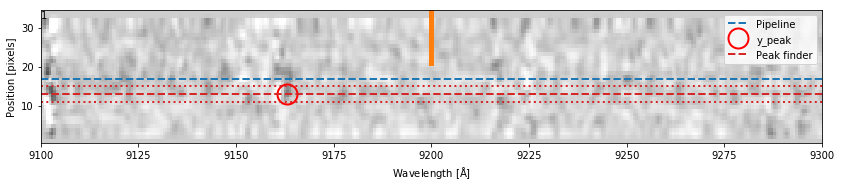

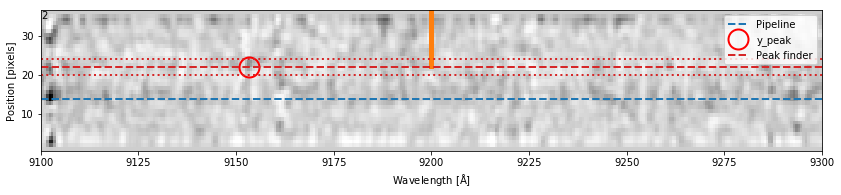

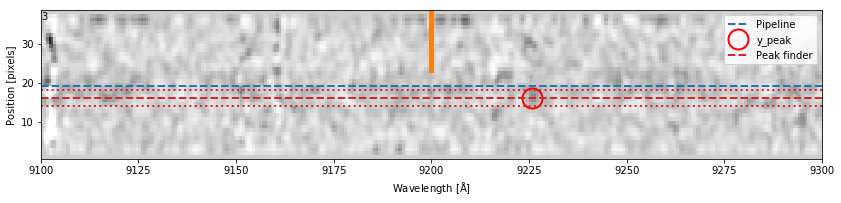

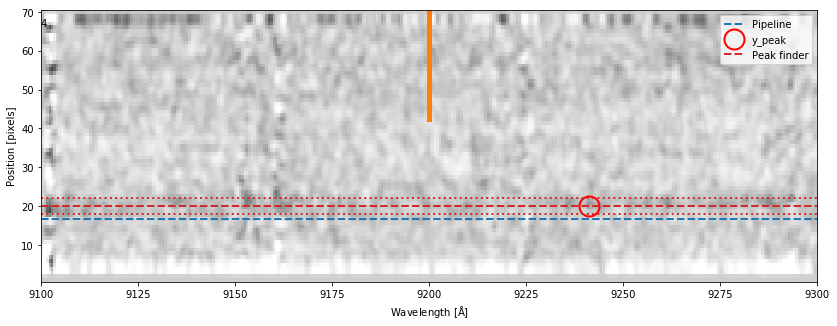

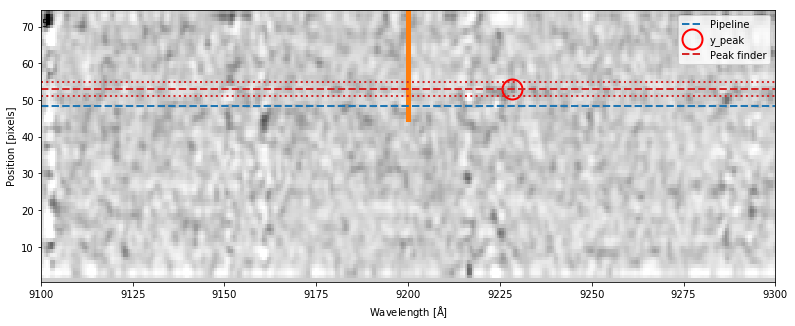

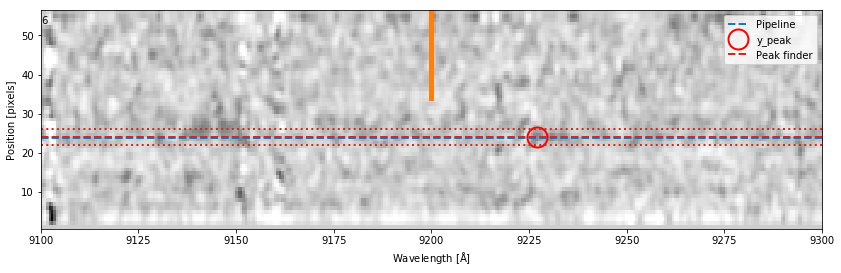

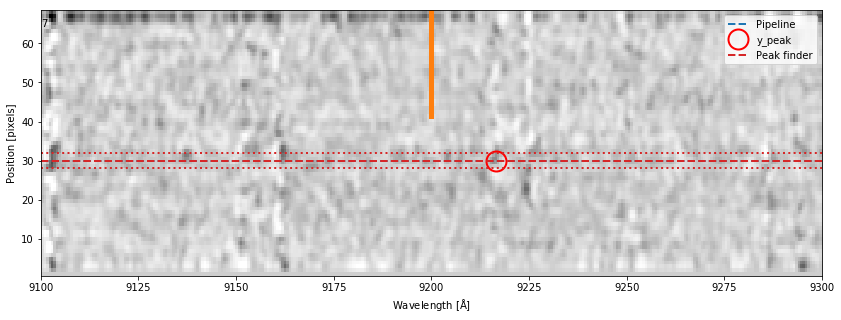

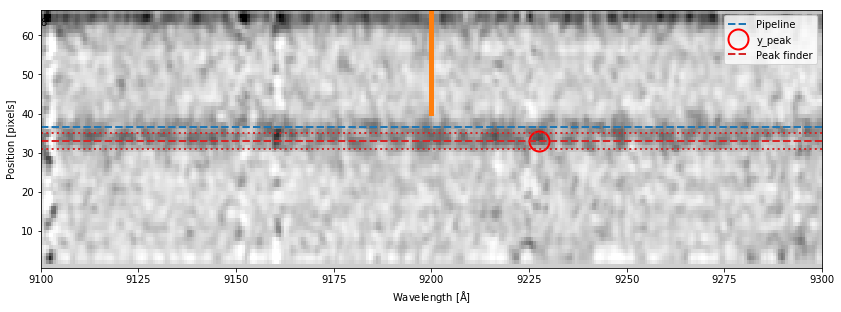

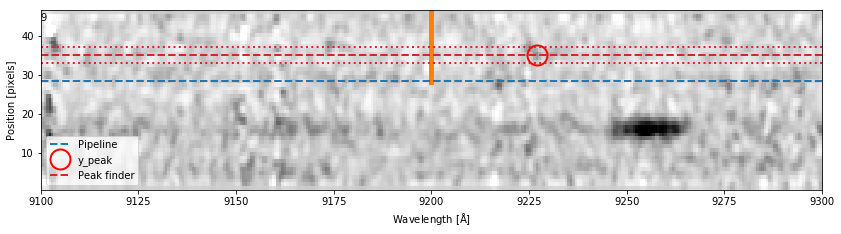

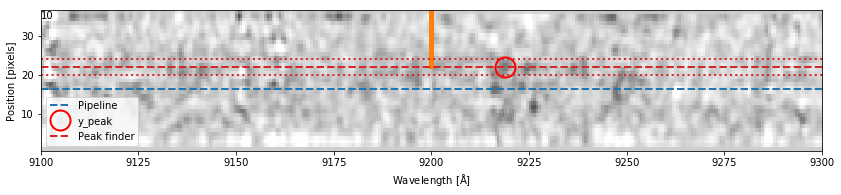

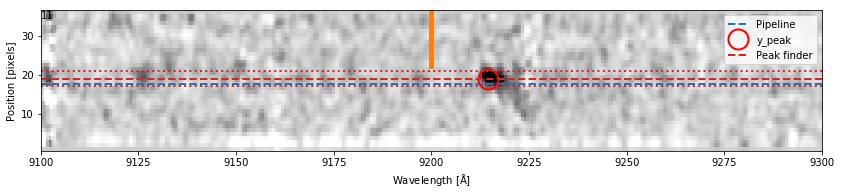

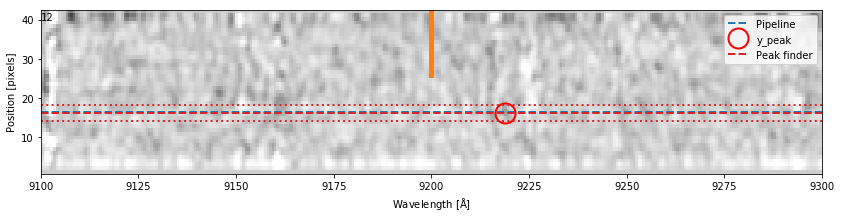

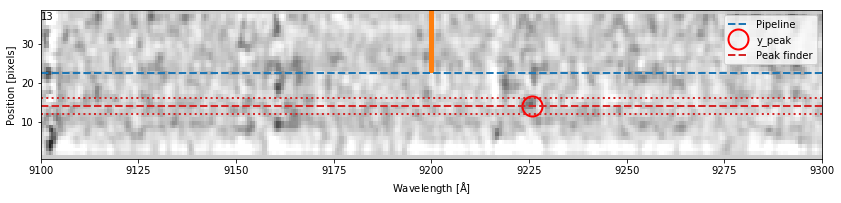

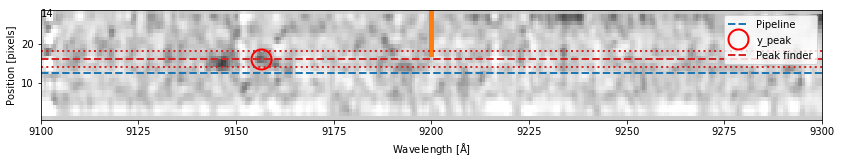

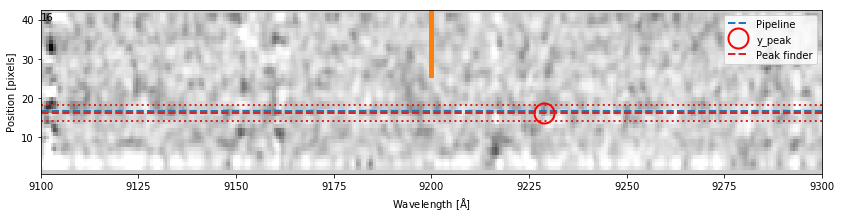

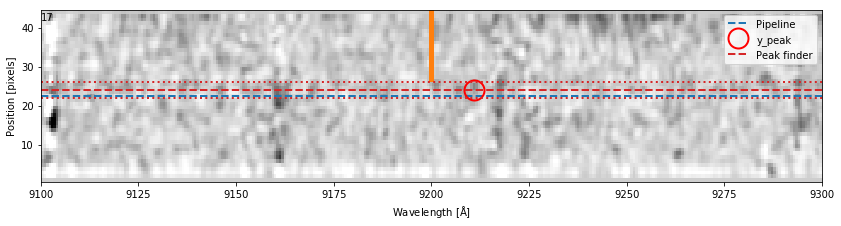

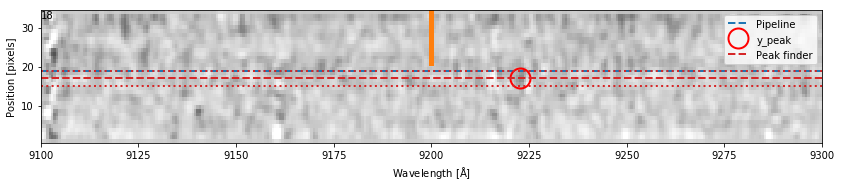

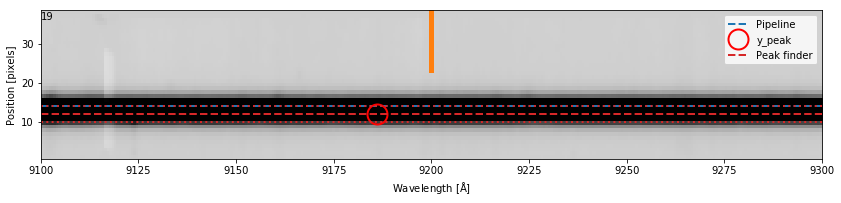

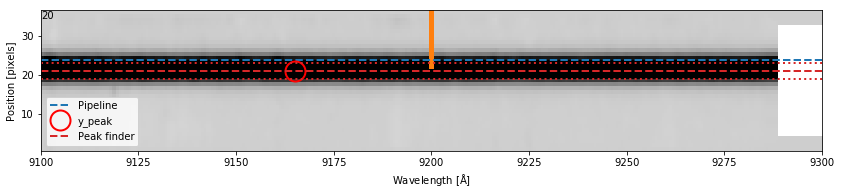

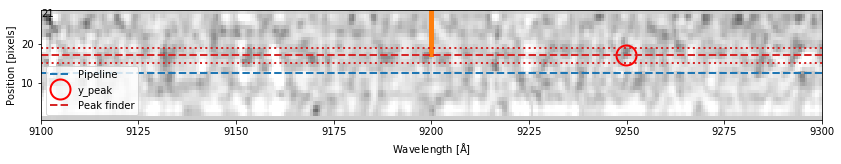

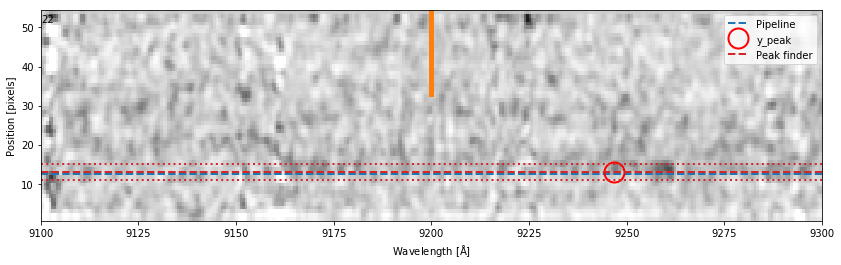

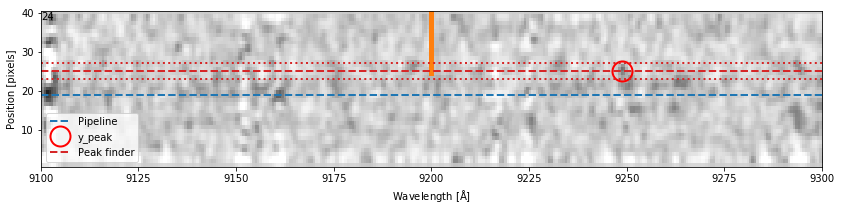

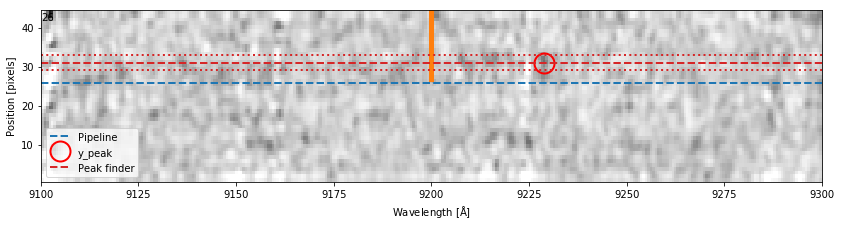

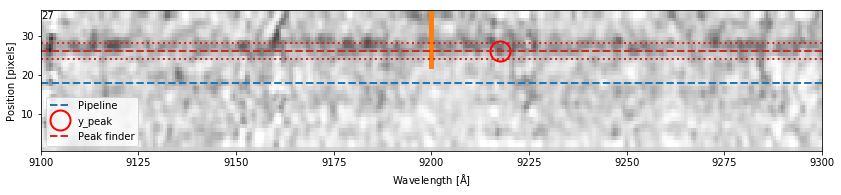

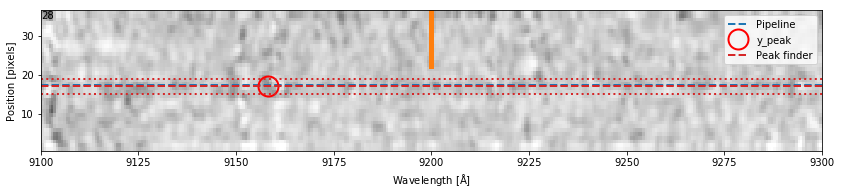

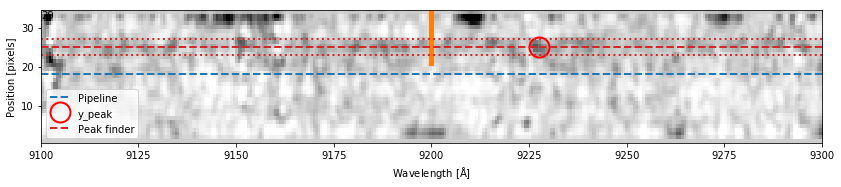

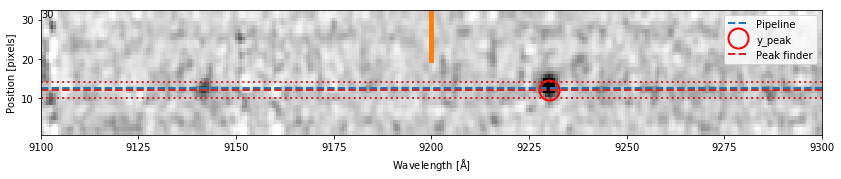

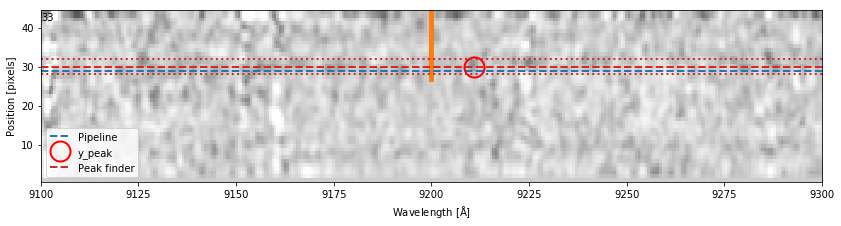

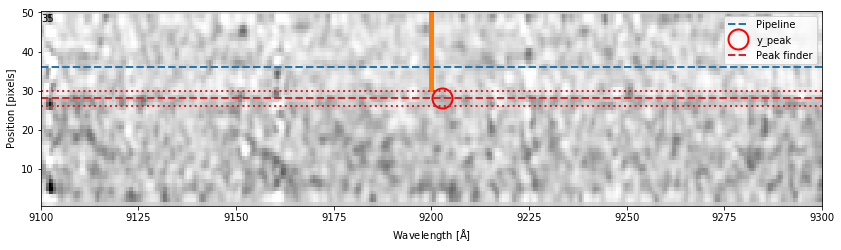

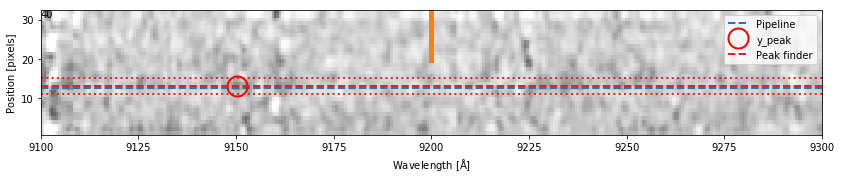

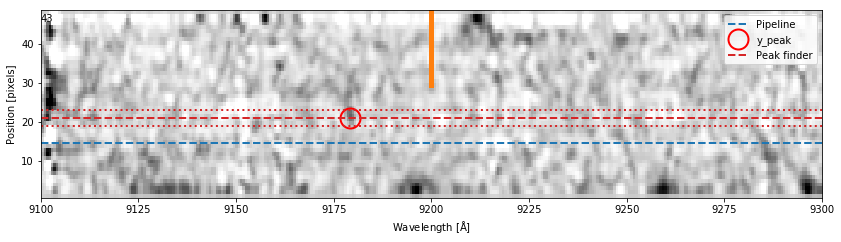

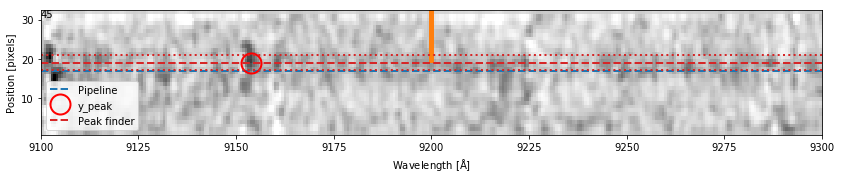

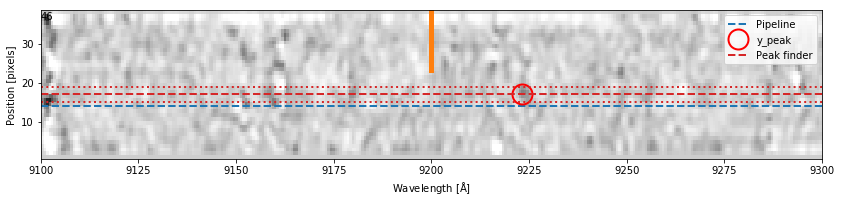

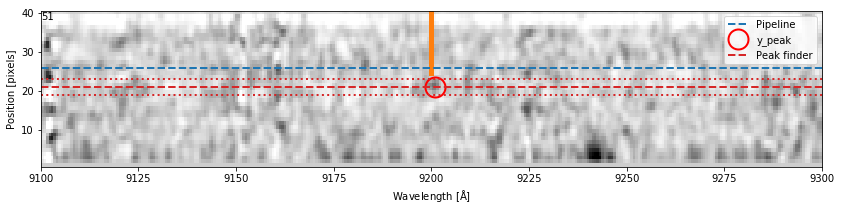

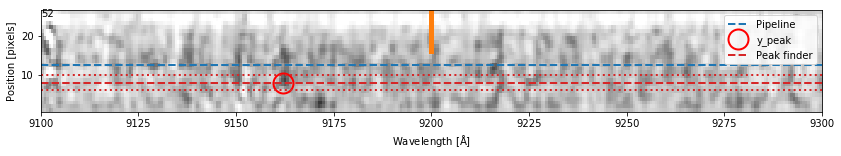

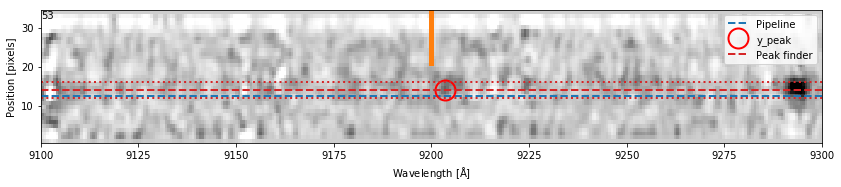

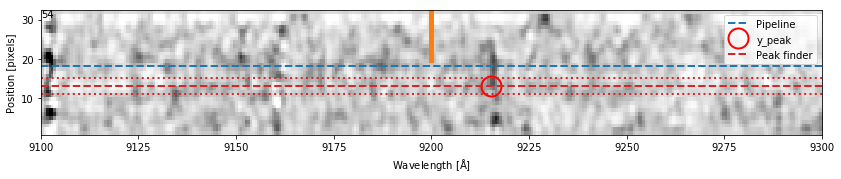

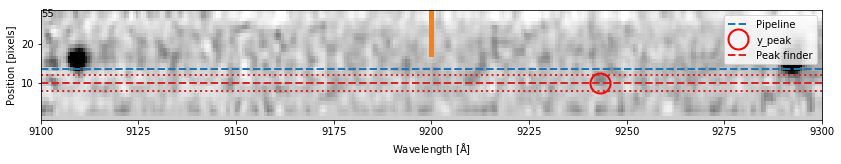

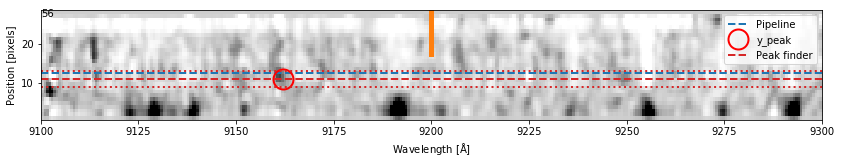

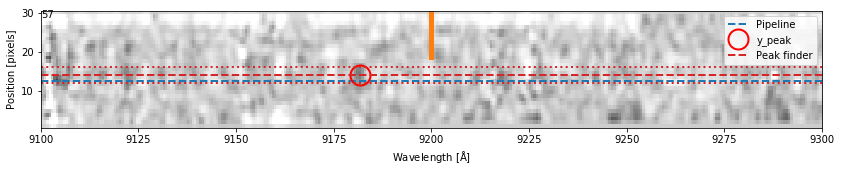

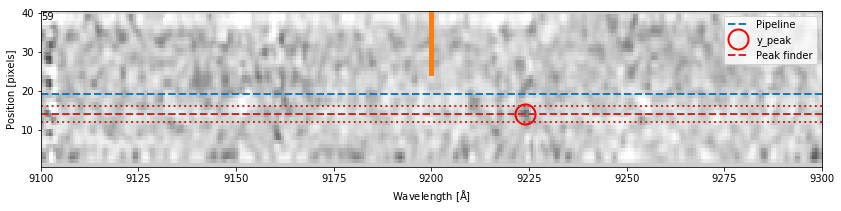

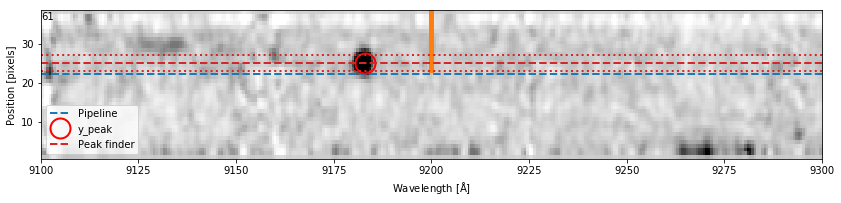

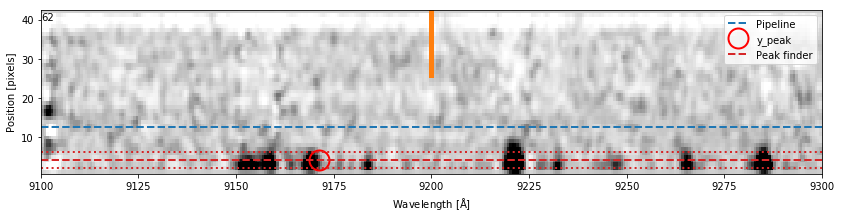

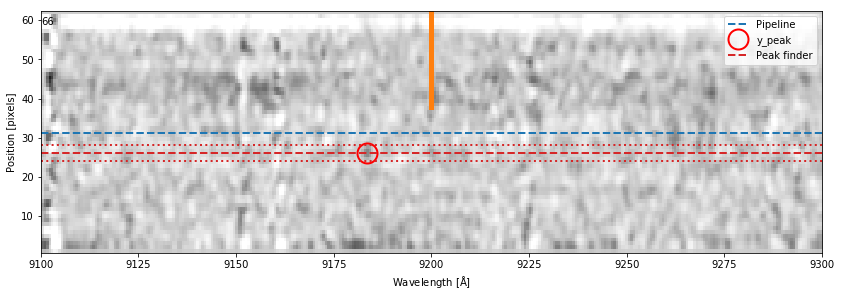

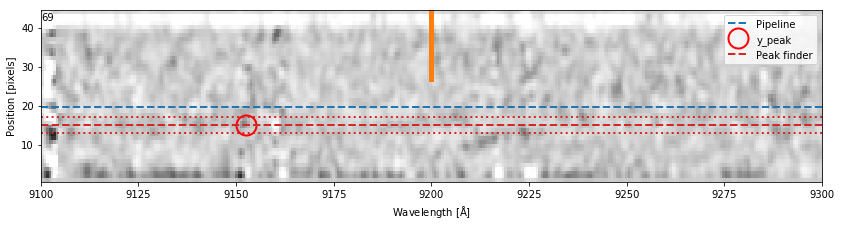

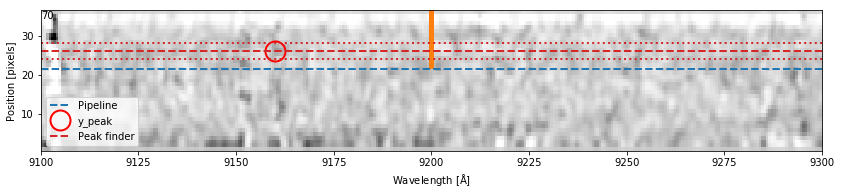

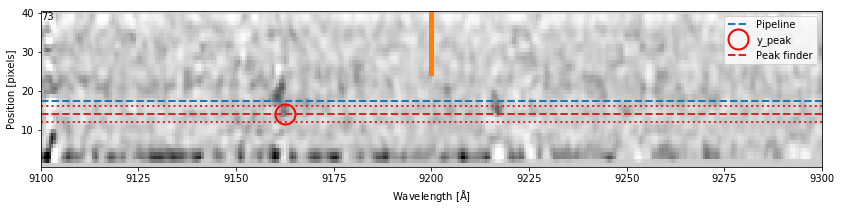

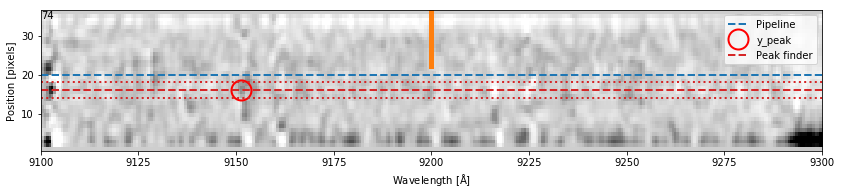

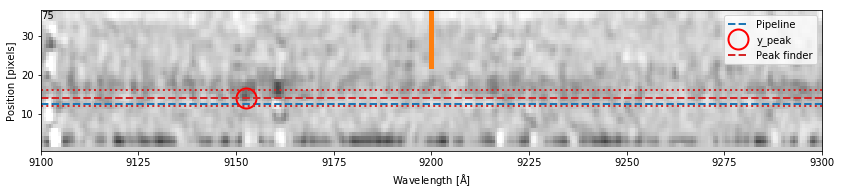

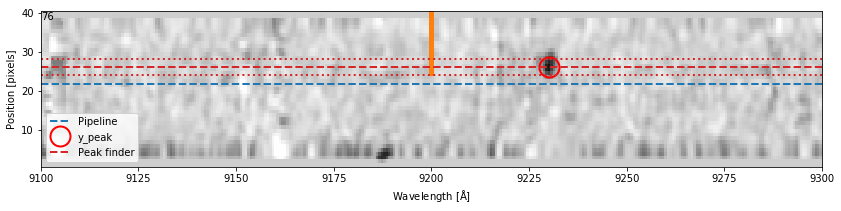

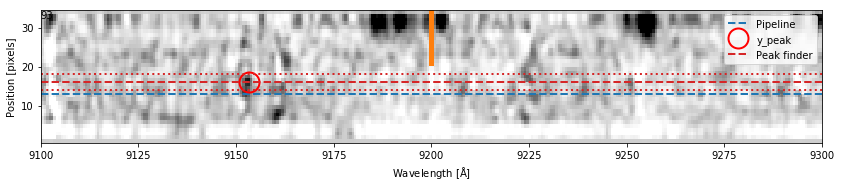

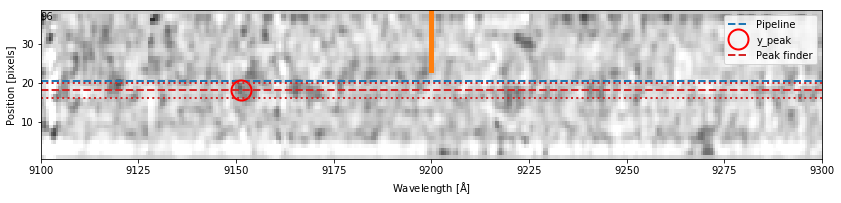

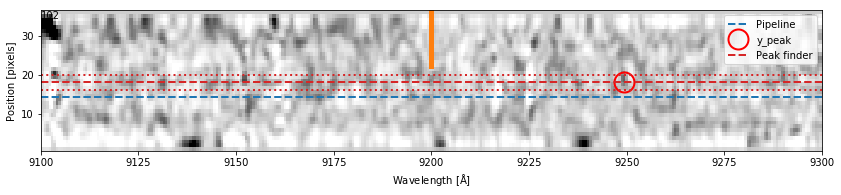

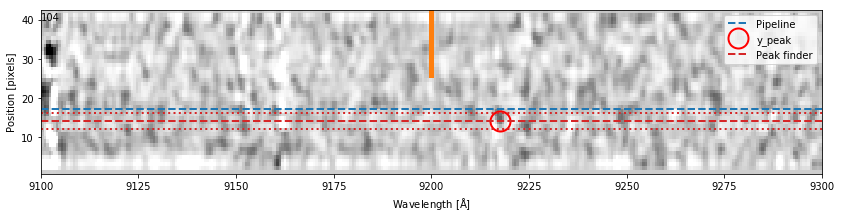

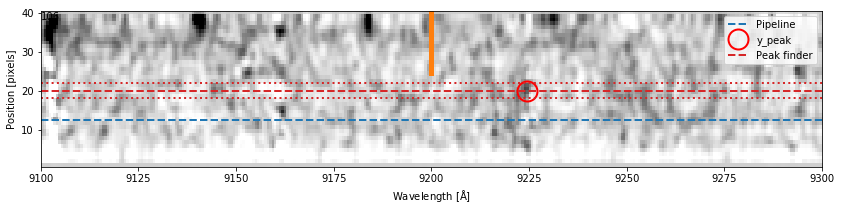

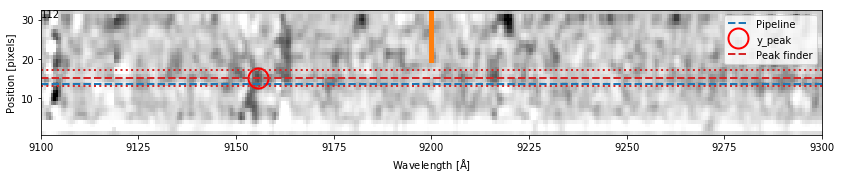

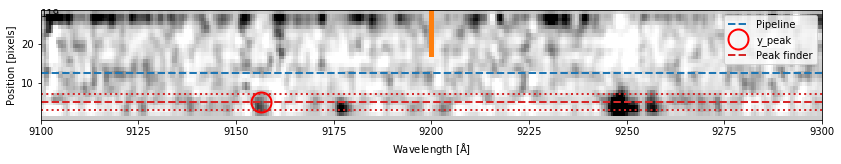

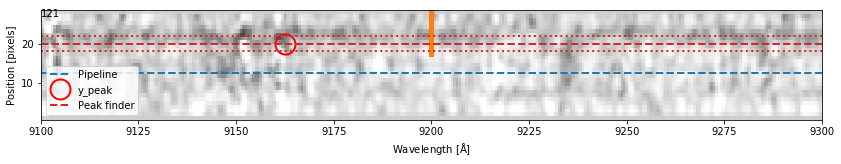

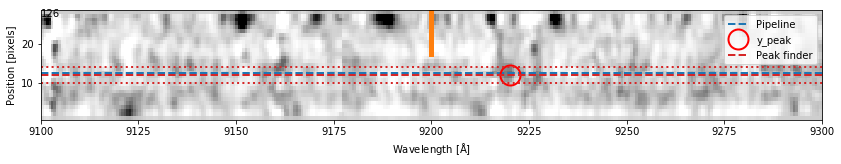

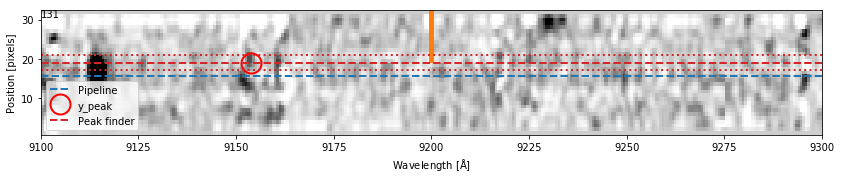

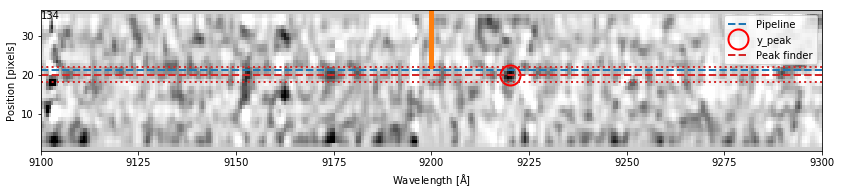

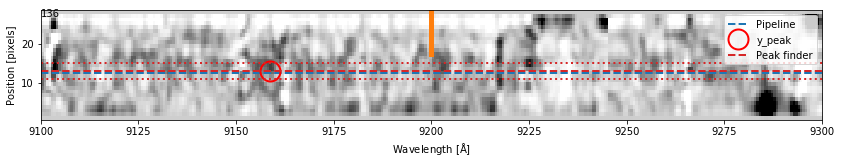

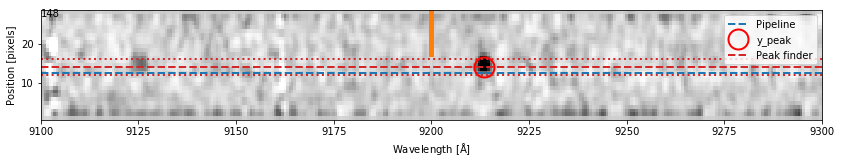

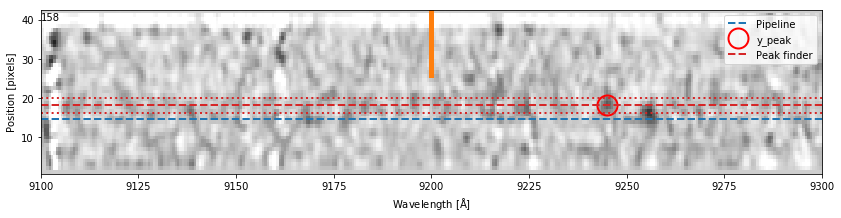

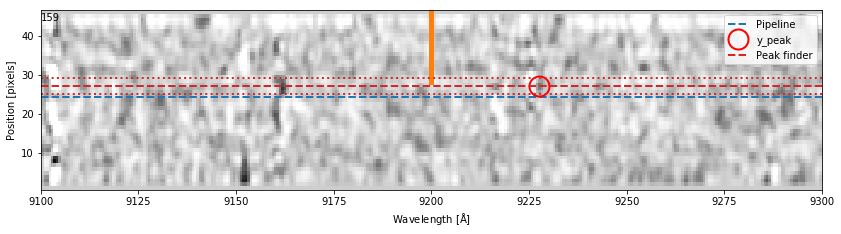

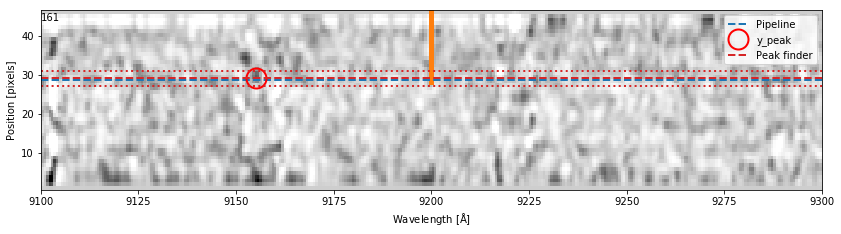

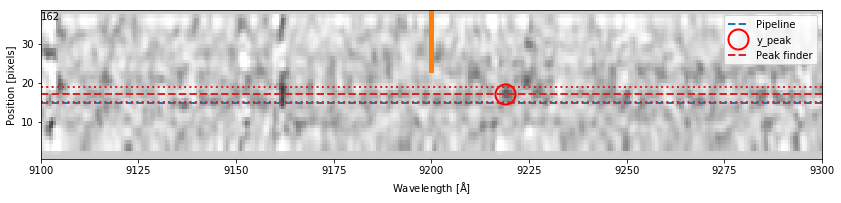

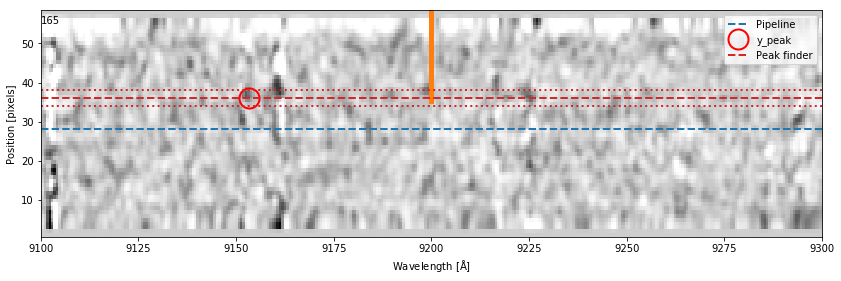

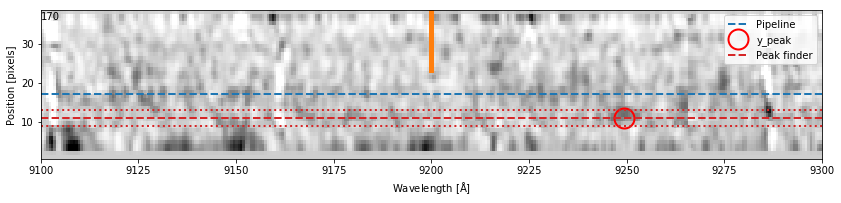

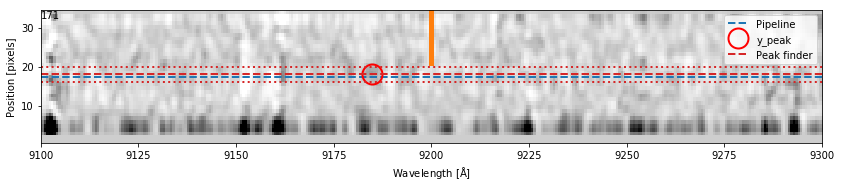

In [28]:
targetid = np.arange(len(target_offset_px))
arcsec_diff= []
for tid in slits_lowz.index:
    ypos = target_offset_px[tid]

    image, ypos_fit = bino_plot.spec2D(target=tid+1, wave_lineA=9200., 
                           posy_width=posy_width, posy=ypos,
                           vmin_sig=-0.3, vmax_sig=0.7, wave_limA=100.,
                           smooth=1., plottitle=tid)

    arcsec_diff.append(((ypos-ypos_fit.data)*px_to_arcsec)[0])

# print(arcsec_diff)

[-0.49999816 -0.11999956]
[4.32393277 1.03774386]


Text(0.5, 0, 'Source offset from mask setup / PSF FWHM')

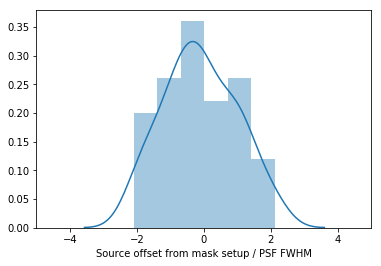

In [29]:
import seaborn as sns
px_to_arcsec = 0.24
px_diff = np.array(arcsec_diff)/px_to_arcsec
px_diff_clip = px_diff[np.where((px_diff <10) & (px_diff>-10))]

print(np.median(px_diff_clip)*np.array([1.,px_to_arcsec]))
print(np.std(px_diff_clip)*np.array([1.,px_to_arcsec]))

sns.distplot(px_diff_clip/4.)
plt.xlim(-5,5)
plt.xlabel('Source offset from mask setup / PSF FWHM')